## Sentence Quality Classification

Classifiy sentences into high / low quality. This is used to improve data quality for texts from different sources (scanned PDFs, crawled HTML, parsed Wikipedia, ..). It's mainly used to filter out artifacts from faulty parsing, HTML fragments, navigation elements, non-sentences (references, titles, ..)

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import load_config
import json
import nltk

### define a new configuration
config_dict = {
    # training data
    "train_file": "data/sentence-quality.csv",
     
    # model
   
    # chose tokenizer. possible values: "nst" and "sgt"
    ## NonStemmingTokenizer: 'nst'
    # - no stemming, only remove punctuation marks
    # - lowercase letters

    ## SimpleGermanTokenizer: 'sgt'
    # - remove punctuation marks
    # - stemming
    # - lowercase letters
    "tokenizer": "nst",
    
    # where to store the configuration file
    "config_path": "data/configuration-sentence-quality-classifier.json"
}

In [2]:
### save config file (don't change)
config_src = config_dict["config_path"]

with open(config_src, 'w+') as f:
    json.dump(config_dict, f, indent=4)
    
# load config object based on config file (don't change)
config = load_config.Configuration(config_src, True)

In [3]:
from tokenizer import get_tokenizer
tokenizer = get_tokenizer(config_dict['tokenizer'])

In [4]:
# load training data
import pandas as pd 

data = pd.read_csv(config['train_file']) 
data = data.sample(frac=1).reset_index(drop=True)

,Satz,Tokens,Klassierung,Bemerkungen,label
0,"Imhoff, München I.J.","['imhoff', 'münchen', 'ij']",REFERENCE,NaN,REFERENCE
1,Er war mit der Malerin Leah Hamilton verheir...,"['er', 'war', 'mit', 'der', 'malerin', 'leah',...",SENTENCE,NaN,SENTENCE
2,"''spinalis'', zur Wirbelsäule/Rückenmark gehör...","['spinalis', 'zur', 'wirbelsäule', 'rückenmark...",LOW_QUALITY,NaN,LOW_QUALITY
3,"__NOINDEX__ <div style=""background-color:#CEFF...","['noindex', 'div', 'style=', 'background-color...",LOW_QUALITY,NaN,LOW_QUALITY
4,Im englischen Sprachraum finden sich die Begri...,"['im', 'englischen', 'sprachraum', 'finden', '...",SENTENCE,NaN,SENTENCE


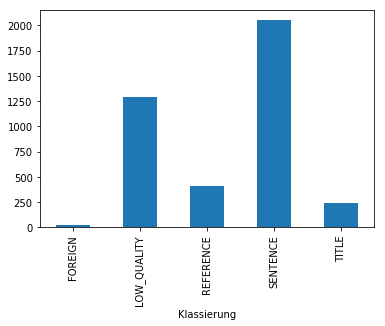

In [5]:
# set targets

data.groupby('Klassierung').Klassierung.count().plot.bar()

#data['label'] = pd.Series(['high' if a else 'low' for a in data['Klassierung'].isin(['SENTENCE'])], index=data.index)
data['label'] = pd.Series(data['Klassierung'], index=data.index)

# set label / classes
classes = list(data['label'].unique())
data.head()

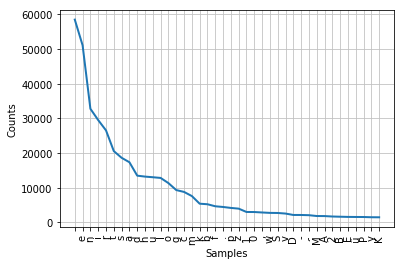

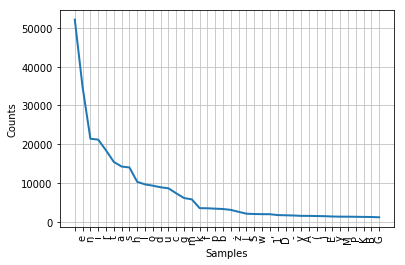

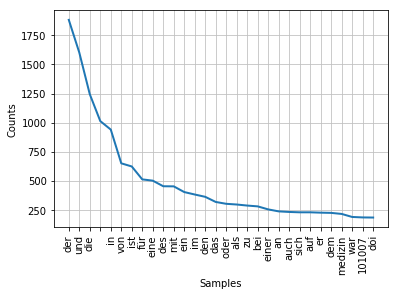

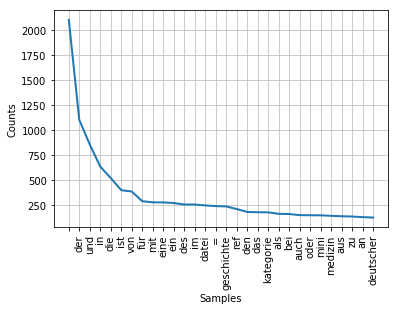

In [8]:
# character frequency analysis

high_quality = data.loc[data['Klassierung'].isin(['SENTENCE', 'REFERENCE'])]
low_quality = data.loc[[not a for a in data['Klassierung'].isin(['SENTENCE', 'REFERENCE'])]]

fdc = nltk.FreqDist()
tokens_h = []
for s in high_quality['Satz']:
    tokens_h.extend(tokenizer.tokenize(s))
    fdc.update(s)
    
# character frequencies
fdc.plot(40,cumulative=False)

tokens_l = []
fdc2 = nltk.FreqDist()
for s in low_quality['Satz']:
    tokens_l.extend(tokenizer.tokenize(s))
    fdc2.update(s)
    fdc.update(s)
    
# character frequencies
fdc2.plot(40,cumulative=False)

# word frequencies
fd = nltk.FreqDist(tokens_h)
fd.plot(30,cumulative=False) 
fd = nltk.FreqDist(tokens_l)
fd.plot(30,cumulative=False) 

In [6]:
# Keras LSTM input data

# one hot encoded characters
from keras.preprocessing.text import Tokenizer
tokenizer_char = Tokenizer(char_level=True)
tokenizer_char.fit_on_texts(data['Satz'])
char_int_encoded = tokenizer_char.texts_to_sequences(data['Satz'])

Using Theano backend.


In [9]:
# set input data

import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=8, norm='l2', encoding='utf8', ngram_range=(2, 2), stop_words='english')
tfidf = tfidf.fit(data.Satz)

fd = nltk.FreqDist(tokens_h + tokens_l)

voc_chars = list(fdc.keys())[:200]
voc_words = list(fd.keys())[:500]

def convert_sentence_to_input(s):
    tokens = tokenizer.tokenize(s)
    fd_words = nltk.FreqDist(tokens)
    fd_chars = nltk.FreqDist(s)
    
    words = [fd_words.freq(w) for w in voc_words]
    chars = [fd_chars.freq(c) for c in voc_chars]
    
    words_in_vocab = sum(1 for i in words if i > 0.0)
    long_tail = float(words_in_vocab) /  len(tokens)
    
    tfidf_features = list(tfidf.transform([s]).toarray()[0])
    
    return np.array(words + chars + [long_tail/10.0], dtype=np.float32)

data['input'] = pd.Series([[convert_sentence_to_input(s)] for s in data['Satz']], index=data.index)
data.head()

,Satz,Tokens,Klassierung,Bemerkungen,label,input
0,"Imhoff, München I.J.","['imhoff', 'münchen', 'ij']",REFERENCE,NaN,REFERENCE,"[[0.333333, 0.333333, 0.333333, 0.0, 0.0, 0.0,..."
1,Er war mit der Malerin Leah Hamilton verheir...,"['er', 'war', 'mit', 'der', 'malerin', 'leah',...",SENTENCE,NaN,SENTENCE,"[[0.0, 0.0, 0.0, 0.125, 0.125, 0.125, 0.125, 0..."
2,"''spinalis'', zur Wirbelsäule/Rückenmark gehör...","['spinalis', 'zur', 'wirbelsäule', 'rückenmark...",LOW_QUALITY,NaN,LOW_QUALITY,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,"__NOINDEX__ <div style=""background-color:#CEFF...","['noindex', 'div', 'style=', 'background-color...",LOW_QUALITY,NaN,LOW_QUALITY,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0454545, 0.0..."
4,Im englischen Sprachraum finden sich die Begri...,"['im', 'englischen', 'sprachraum', 'finden', '...",SENTENCE,NaN,SENTENCE,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


In [10]:
# fit a model

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.neural_network import MLPClassifier

models = [
    RandomForestClassifier(n_estimators=200, max_depth=4, random_state=0),
    RandomForestClassifier(n_estimators=200, max_depth=8, random_state=0),
    RandomForestClassifier(n_estimators=200, max_depth=16, random_state=0),
    RandomForestClassifier(n_estimators=200, max_depth=32, random_state=0),
    RandomForestClassifier(n_estimators=200, max_depth=64, random_state=0),
    RandomForestClassifier(n_estimators=200, max_depth=128, random_state=0),
    LinearSVC(),
    # MultinomialNB(),
    LogisticRegression(random_state=0),
    SVC(kernel='linear', gamma=2),
    # SVC(kernel='poly', gamma=2),
    SVC(kernel='rbf', gamma=2),
    MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(8), random_state=1),
    MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(16), random_state=1),
    MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(32), random_state=1),
    MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(32, 16), random_state=1),
    MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(32, 16, 8), random_state=1)
]

X_train, X_test, char_int_encoded_train, char_int_encoded_test, y_train, y_test = train_test_split(np.array([e[0] for e in data['input']]), char_int_encoded, data['label'], random_state = 2)

print(X_train.shape)

# count_vect = CountVectorizer()
# X_train_counts = count_vect.fit_transform(X_train)
# tfidf_transformer = TfidfTransformer()
# X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

models = [model.fit(X_train, y_train) for model in models]


(3003, 701)


RandomForestClassifier: 0.701298701299
RandomForestClassifier: 0.751248751249
RandomForestClassifier: 0.77022977023
RandomForestClassifier: 0.785214785215
RandomForestClassifier: 0.78021978022
RandomForestClassifier: 0.779220779221
LinearSVC: 0.715284715285
LogisticRegression: 0.622377622378
SVC: 0.634365634366
SVC: 0.707292707293
MLPClassifier: 0.749250749251
MLPClassifier: 0.729270729271
MLPClassifier: 0.755244755245
MLPClassifier: 0.749250749251
MLPClassifier: 0.729270729271


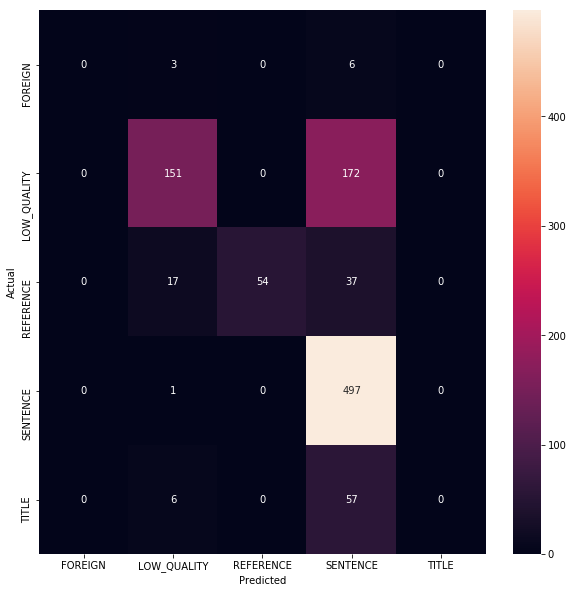

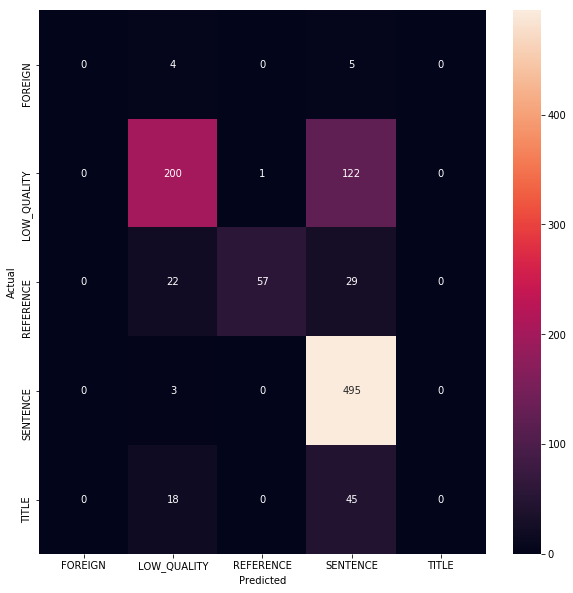

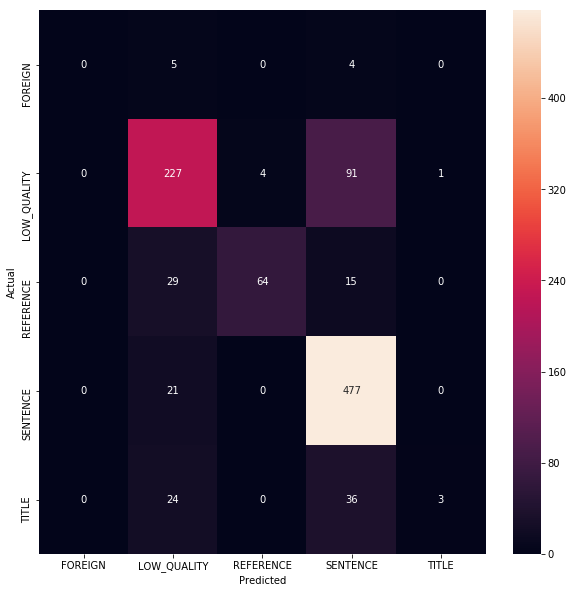

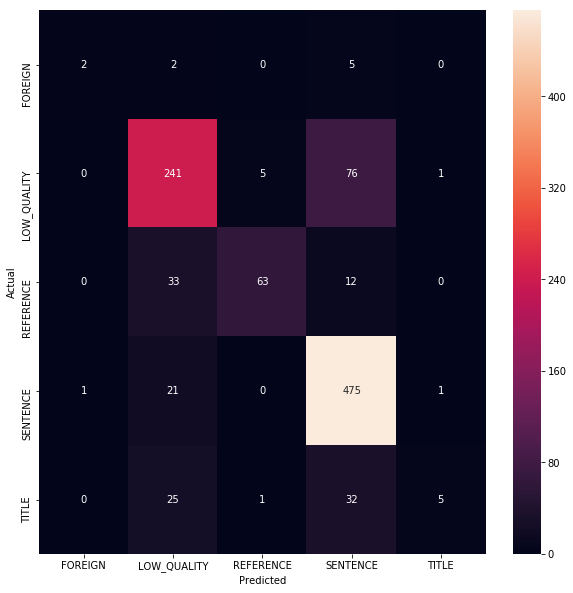

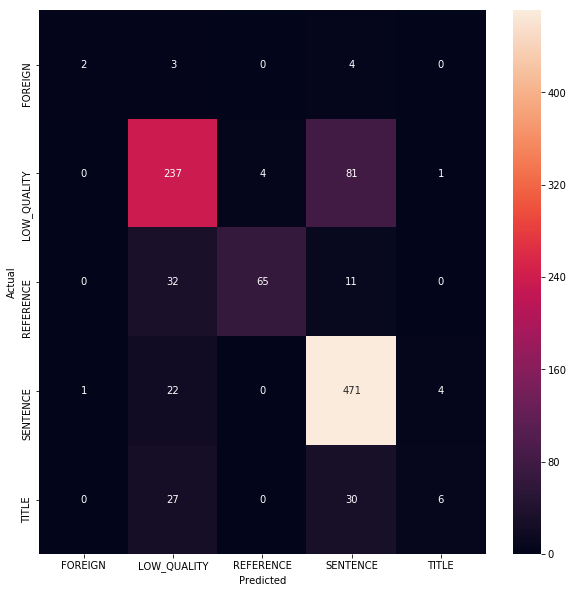

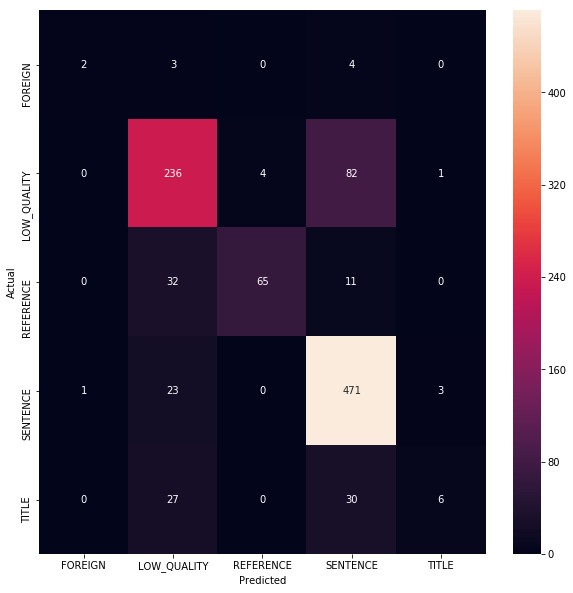

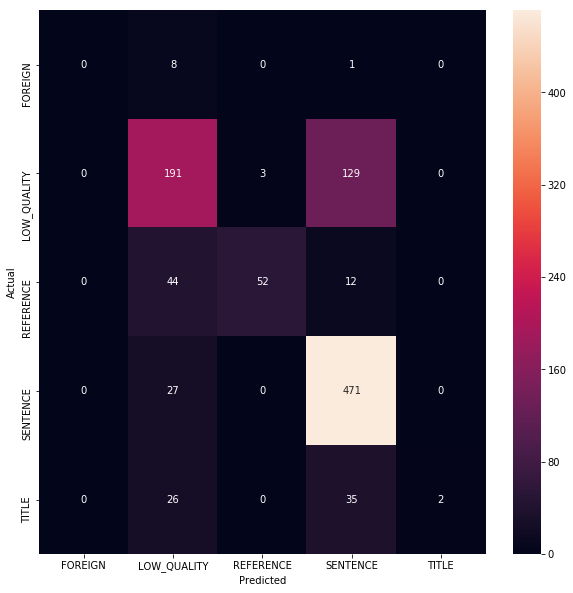

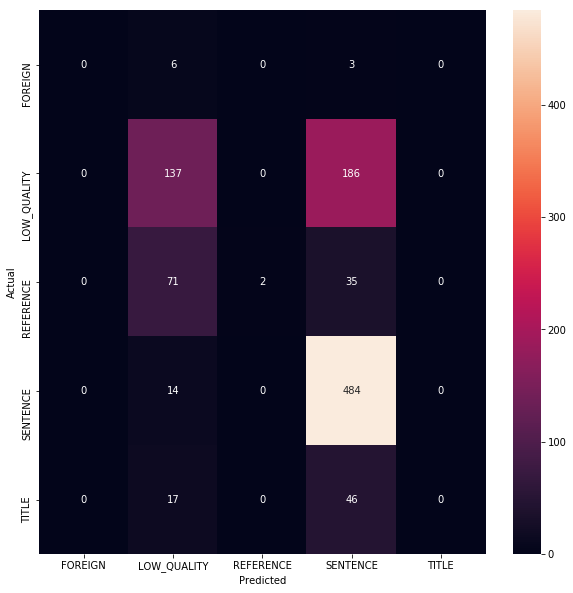

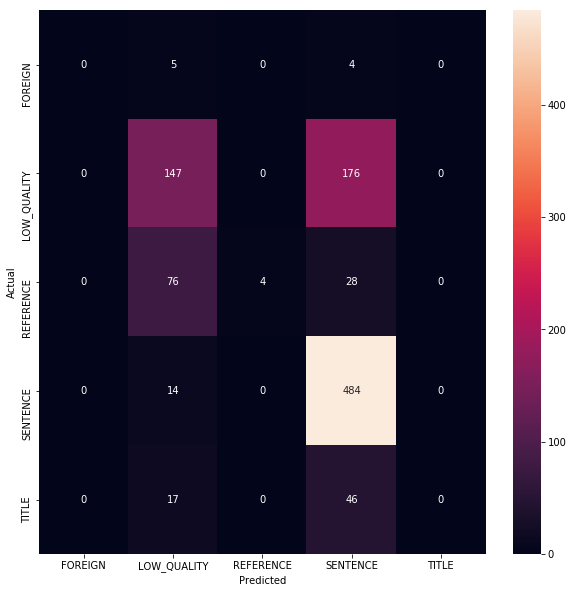

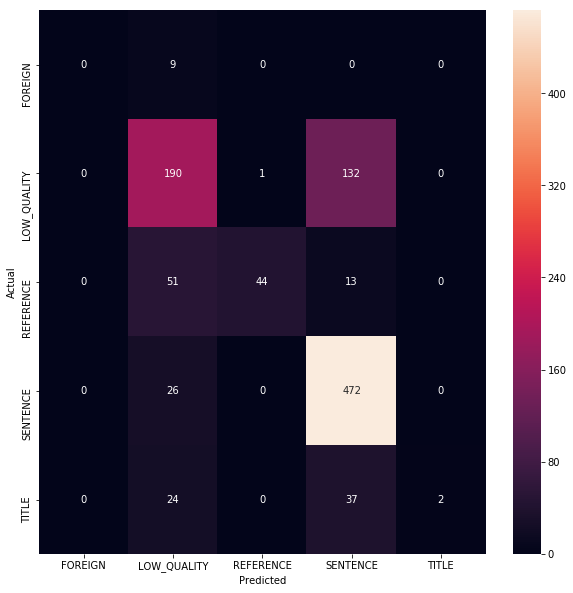

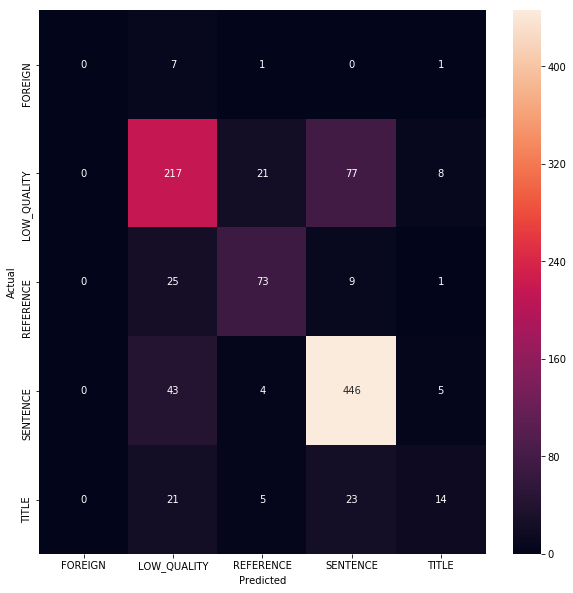

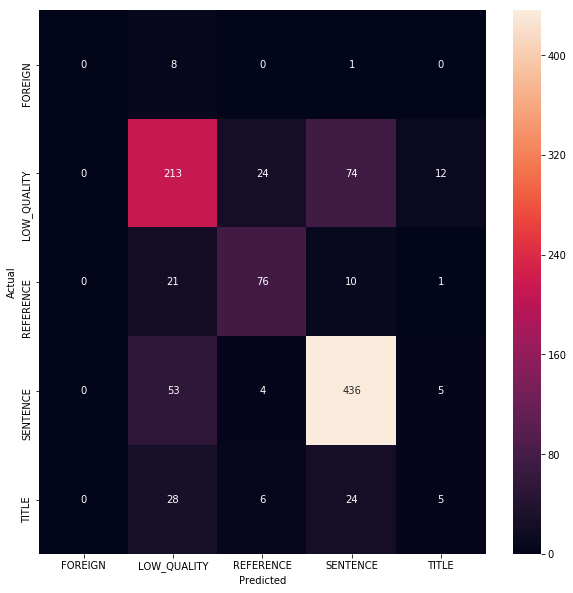

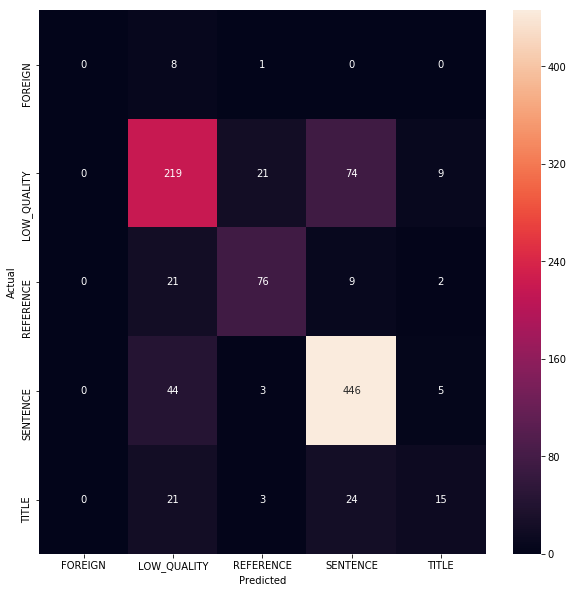

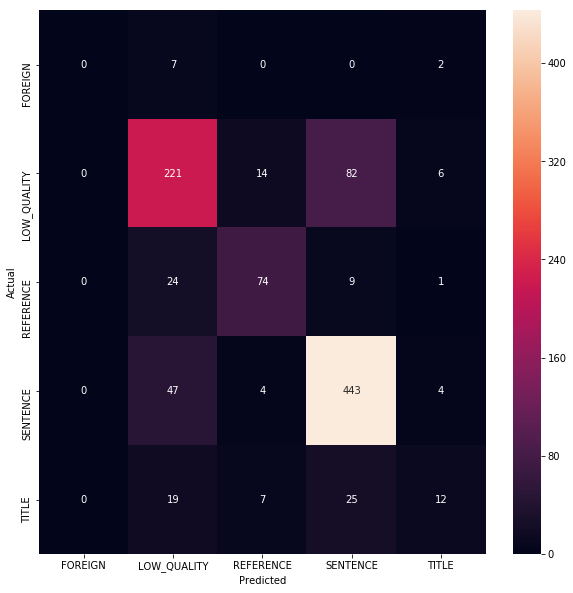

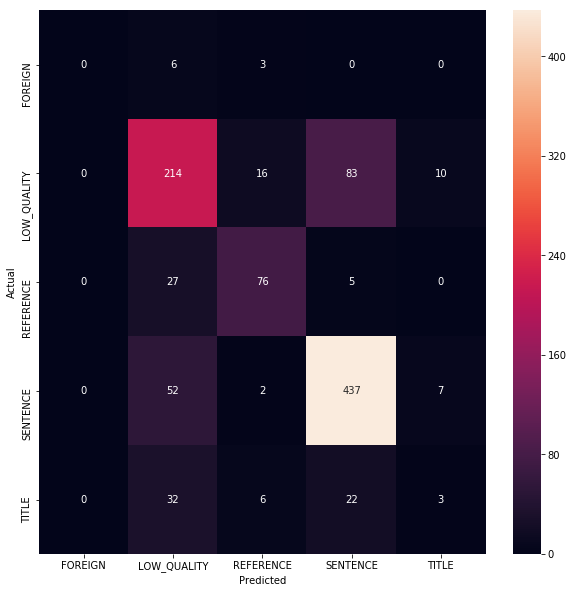

In [11]:
# model evaluation

for model in models:
    y_pred = model.predict(X_test)
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import accuracy_score

    print(model.__class__.__name__ + ": " + str(accuracy_score(y_test, y_pred)))

    conf_mat = confusion_matrix(y_test, y_pred)

    import matplotlib.pyplot as plt
    import seaborn as sns

    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(conf_mat, annot=True, fmt='d',
                xticklabels=model.classes_, yticklabels=model.classes_)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    # plt.show()

In [13]:
# Keras MLP
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

batch_size = 128
num_classes = len(classes)
epochs = 1000


# encode class values as integers
encoder = LabelEncoder()
encoder.fit(y_train)
encoded_y_train = encoder.transform(y_train)
encoded_y_test = encoder.transform(y_test)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y_train = np_utils.to_categorical(encoded_y_train)
dummy_y_test = np_utils.to_categorical(encoded_y_test)

model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

# early stopping criterion
early_stopping = EarlyStopping(monitor='val_acc', patience=20)

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

history = model.fit(X_train, dummy_y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_test, dummy_y_test),
                    callbacks=[early_stopping])
score = model.evaluate(X_test, dummy_y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               89856     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 645       
Total params: 90,501
Trainable params: 90,501
Non-trainable params: 0
_________________________________________________________________
Train on 3003 samples, validate on 1001 samples
Epoch 1/1000
3003/3003 [==============================] - 0s - loss: 1.4416 - acc: 0.4995 - val_loss: 1.3160 - val_acc: 0.4975
Epoch 2/1000
3003/3003 [==============================] - 0s - loss: 1.2161 - acc: 0.5178 - val_loss: 1.1740 - val_acc: 0.4995
Epoch 3/1000
3003/3003 [==============================] - 0s - loss: 1.1080 - acc: 0.5238 - val_loss

3003/3003 [==============================] - 0s - loss: 0.4907 - acc: 0.8105 - val_loss: 0.6626 - val_acc: 0.7512
Epoch 59/1000
3003/3003 [==============================] - 0s - loss: 0.4867 - acc: 0.8135 - val_loss: 0.6622 - val_acc: 0.7522
Epoch 60/1000
3003/3003 [==============================] - 0s - loss: 0.4849 - acc: 0.8095 - val_loss: 0.6625 - val_acc: 0.7562
Epoch 61/1000
3003/3003 [==============================] - 0s - loss: 0.4796 - acc: 0.8129 - val_loss: 0.6649 - val_acc: 0.7532
Epoch 62/1000
3003/3003 [==============================] - 0s - loss: 0.4781 - acc: 0.8122 - val_loss: 0.6635 - val_acc: 0.7562
Epoch 63/1000
3003/3003 [==============================] - 0s - loss: 0.4734 - acc: 0.8139 - val_loss: 0.6626 - val_acc: 0.7522
Epoch 64/1000
3003/3003 [==============================] - 0s - loss: 0.4742 - acc: 0.8175 - val_loss: 0.6731 - val_acc: 0.7483
Epoch 65/1000
3003/3003 [==============================] - 0s - loss: 0.4690 - acc: 0.8195 - val_loss: 0.6703 - val_ac

3003/3003 [==============================] - 0s - loss: 0.3705 - acc: 0.8675 - val_loss: 0.6945 - val_acc: 0.7762
Epoch 122/1000
3003/3003 [==============================] - 0s - loss: 0.3668 - acc: 0.8601 - val_loss: 0.6968 - val_acc: 0.7762
Epoch 123/1000
3003/3003 [==============================] - 0s - loss: 0.3698 - acc: 0.8535 - val_loss: 0.7068 - val_acc: 0.7682
Epoch 124/1000
3003/3003 [==============================] - 0s - loss: 0.3634 - acc: 0.8595 - val_loss: 0.7062 - val_acc: 0.7572
Epoch 125/1000
3003/3003 [==============================] - 0s - loss: 0.3667 - acc: 0.8565 - val_loss: 0.7010 - val_acc: 0.7712
Epoch 126/1000
3003/3003 [==============================] - 0s - loss: 0.3641 - acc: 0.8651 - val_loss: 0.7005 - val_acc: 0.7752
Epoch 127/1000
3003/3003 [==============================] - 0s - loss: 0.3631 - acc: 0.8671 - val_loss: 0.7019 - val_acc: 0.7702
Epoch 128/1000
3003/3003 [==============================] - 0s - loss: 0.3618 - acc: 0.8635 - val_loss: 0.7028 -

In [16]:
# Keras LSTM

from keras.models import Sequential
from keras.layers import *
n_symbols = len(tokenizer_char.word_index) + 1
seq_length = 64
embedding_size = 20

char_int_encoded_train = keras.preprocessing.sequence.pad_sequences(
            char_int_encoded_train, maxlen=seq_length, dtype='int', truncating='pre')
char_int_encoded_test = keras.preprocessing.sequence.pad_sequences(
            char_int_encoded_test, maxlen=seq_length, dtype='int', truncating='pre')

model = Sequential()
model.add(Embedding(input_dim=n_symbols,
                          output_dim=embedding_size,
                          input_length=seq_length,
                          mask_zero=False))
model.add(LSTM(32, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(16, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

history = model.fit(char_int_encoded_train, encoded_y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(char_int_encoded_test, encoded_y_test),
                    callbacks=[early_stopping])
score = model.evaluate(char_int_encoded_test, encoded_y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 64, 20)            5880      
_________________________________________________________________
lstm_3 (LSTM)                (None, 32)                6784      
_________________________________________________________________
dense_5 (Dense)              (None, 16)                528       
Total params: 13,192
Trainable params: 13,192
Non-trainable params: 0
_________________________________________________________________
Train on 3003 samples, validate on 1001 samples
Epoch 1/1000
3003/3003 [==============================] - 3s - loss: 2.6535 - acc: 0.4855 - val_loss: 2.3038 - val_acc: 0.4975
Epoch 2/1000
3003/3003 [==============================] - 3s - loss: 1.5810 - acc: 0.5168 - val_loss: 1.3429 - val_acc: 0.4975
Epoch 3/1000
3003/3003 [==============================] - 3s - loss: 1.2176 - acc: 0.5165 - val_loss

KeyboardInterrupt: 